In [48]:
import os
from os.path import join
import torch
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/utils")
from pixart_utils import state_dict_convert
from image_utils import pil_images_to_grid
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler


In [49]:
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
@torch.inference_mode()
def visualize_prompts(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(0)
    image_logs = []
    images = []
    latents = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        latents.append(pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            output_type="latent",
        ).images)
        visualized_prompts.append(prompt)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})

    return image_logs

In [288]:
@torch.inference_mode()
def load_embed_and_mask(validation_prompts, prompt_cache_dir, max_length=120, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    embed_infos = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        embed_infos.append({"caption_embeds": caption_embs, "emb_mask": emb_masks, "prompt": prompt})
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    embed_infos.append({"caption_embeds": uncond_prompt_embeds, "emb_mask": uncond_prompt_attention_mask, "prompt": ""})
    return embed_infos

In [62]:
@torch.inference_mode()
def visualize_prompts_with_traj(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(0)
    image_logs = []
    images = []
    latents = []
    pred_traj = []
    latents_traj = []
    t_traj = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        output = pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            return_sample_pred_traj=True,
            output_type="latent",
        )
        latents.append(output[0].images)
        pred_traj.append(output[1])
        latents_traj.append(output[2])
        t_traj.append(output[3])
        visualized_prompts.append(prompt)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})

    return image_logs, latents_traj, pred_traj, t_traj

### Customize the PixArt pipeline to facilitate hooking

In [235]:
# subclass a new pipeline from PixArtAlphaPipeline
from typing import Callable, List, Optional, Tuple, Union
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from diffusers.pipelines.pixart_alpha.pipeline_pixart_alpha import retrieve_timesteps
# from diffusers.pipelines.pixart_alpha import EXAMPLE_DOC_STRING, ImagePipelineOutput
class PixArtAlphaPipeline_custom(PixArtAlphaPipeline):
    
    # @replace_example_docstring(EXAMPLE_DOC_STRING)
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        negative_prompt: str = "",
        num_inference_steps: int = 20,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: float = 4.5,
        num_images_per_prompt: Optional[int] = 1,
        height: Optional[int] = None,
        width: Optional[int] = None,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.Tensor], None]] = None,
        callback_steps: int = 1,
        clean_caption: bool = True,
        use_resolution_binning: bool = True,
        max_sequence_length: int = 120,
        return_sample_pred_traj: bool = False,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        """
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process with schedulers which support a `timesteps` argument
                in their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is
                passed will be used. Must be in descending order.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 4.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            height (`int`, *optional*, defaults to self.unet.config.sample_size):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size):
                The width in pixels of the generated image.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.Tensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            prompt_attention_mask (`torch.Tensor`, *optional*): Pre-generated attention mask for text embeddings.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. For PixArt-Alpha this negative prompt should be "". If not
                provided, negative_prompt_embeds will be generated from `negative_prompt` input argument.
            negative_prompt_attention_mask (`torch.Tensor`, *optional*):
                Pre-generated attention mask for negative text embeddings.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.IFPipelineOutput`] instead of a plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.Tensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            clean_caption (`bool`, *optional*, defaults to `True`):
                Whether or not to clean the caption before creating embeddings. Requires `beautifulsoup4` and `ftfy` to
                be installed. If the dependencies are not installed, the embeddings will be created from the raw
                prompt.
            use_resolution_binning (`bool` defaults to `True`):
                If set to `True`, the requested height and width are first mapped to the closest resolutions using
                `ASPECT_RATIO_1024_BIN`. After the produced latents are decoded into images, they are resized back to
                the requested resolution. Useful for generating non-square images.
            max_sequence_length (`int` defaults to 120): Maximum sequence length to use with the `prompt`.

        Examples:

        Returns:
            [`~pipelines.ImagePipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.ImagePipelineOutput`] is returned, otherwise a `tuple` is
                returned where the first element is a list with the generated images
        """
        if "mask_feature" in kwargs:
            deprecation_message = "The use of `mask_feature` is deprecated. It is no longer used in any computation and that doesn't affect the end results. It will be removed in a future version."
            # deprecate("mask_feature", "1.0.0", deprecation_message, standard_warn=False)
        # 1. Check inputs. Raise error if not correct
        height = height or self.transformer.config.sample_size * self.vae_scale_factor
        width = width or self.transformer.config.sample_size * self.vae_scale_factor
        # if use_resolution_binning:
        #     if self.transformer.config.sample_size == 128:
        #         aspect_ratio_bin = ASPECT_RATIO_1024_BIN
        #     elif self.transformer.config.sample_size == 64:
        #         aspect_ratio_bin = ASPECT_RATIO_512_BIN
        #     elif self.transformer.config.sample_size == 32:
        #         aspect_ratio_bin = ASPECT_RATIO_256_BIN
        #     else:
        #         raise ValueError("Invalid sample size")
        #     orig_height, orig_width = height, width
        #     height, width = self.image_processor.classify_height_width_bin(height, width, ratios=aspect_ratio_bin)

        self.check_inputs(
            prompt,
            height,
            width,
            negative_prompt,
            callback_steps,
            prompt_embeds,
            negative_prompt_embeds,
            prompt_attention_mask,
            negative_prompt_attention_mask,
        )

        # 2. Default height and width to transformer
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        (
            prompt_embeds,
            prompt_attention_mask,
            negative_prompt_embeds,
            negative_prompt_attention_mask,
        ) = self.encode_prompt(
            prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images_per_prompt,
            device=device,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            prompt_attention_mask=prompt_attention_mask,
            negative_prompt_attention_mask=negative_prompt_attention_mask,
            clean_caption=clean_caption,
            max_sequence_length=max_sequence_length,
        )
        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            prompt_attention_mask = torch.cat([negative_prompt_attention_mask, prompt_attention_mask], dim=0)
        print(prompt_embeds.shape)
        print(prompt_attention_mask.shape)
        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )

        # 5. Prepare latents.
        latent_channels = self.transformer.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            latent_channels,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Prepare micro-conditions.
        added_cond_kwargs = {"resolution": None, "aspect_ratio": None}
        if self.transformer.config.sample_size == 128:
            resolution = torch.tensor([height, width]).repeat(batch_size * num_images_per_prompt, 1)
            aspect_ratio = torch.tensor([float(height / width)]).repeat(batch_size * num_images_per_prompt, 1)
            resolution = resolution.to(dtype=prompt_embeds.dtype, device=device)
            aspect_ratio = aspect_ratio.to(dtype=prompt_embeds.dtype, device=device)

            if do_classifier_free_guidance:
                resolution = torch.cat([resolution, resolution], dim=0)
                aspect_ratio = torch.cat([aspect_ratio, aspect_ratio], dim=0)

            added_cond_kwargs = {"resolution": resolution, "aspect_ratio": aspect_ratio}

        # 7. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        pred_traj = []
        latents_traj = []
        t_traj = []
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                current_timestep = t
                if not torch.is_tensor(current_timestep):
                    # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
                    # This would be a good case for the `match` statement (Python 3.10+)
                    is_mps = latent_model_input.device.type == "mps"
                    if isinstance(current_timestep, float):
                        dtype = torch.float32 if is_mps else torch.float64
                    else:
                        dtype = torch.int32 if is_mps else torch.int64
                    current_timestep = torch.tensor([current_timestep], dtype=dtype, device=latent_model_input.device)
                elif len(current_timestep.shape) == 0:
                    current_timestep = current_timestep[None].to(latent_model_input.device)
                # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
                current_timestep = current_timestep.expand(latent_model_input.shape[0])

                # predict noise model_output
                noise_pred = self.transformer(
                    latent_model_input,
                    encoder_hidden_states=prompt_embeds,
                    encoder_attention_mask=prompt_attention_mask,
                    timestep=current_timestep,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # learned sigma
                if self.transformer.config.out_channels // 2 == latent_channels:
                    noise_pred = noise_pred.chunk(2, dim=1)[0]
                else:
                    noise_pred = noise_pred

                latents_traj.append(latents)
                pred_traj.append(noise_pred)
                # compute previous image: x_t -> x_t-1
                if num_inference_steps == 1:
                    # For DMD one step sampling: https://arxiv.org/abs/2311.18828
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).pred_original_sample
                else:
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                
                # pred_traj.append(self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).pred_original_sample)
                
                t_traj.append(t)
                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        latents_traj.append(latents)
        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            # if use_resolution_binning:
            #     image = self.image_processor.resize_and_crop_tensor(image, orig_width, orig_height)
        else:
            image = latents

        if not output_type == "latent":
            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)
        if return_sample_pred_traj:
            return ImagePipelineOutput(images=image), pred_traj, latents_traj, t_traj
        return ImagePipelineOutput(images=image)

In [236]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"


config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

2024-11-27 23:19:26,871 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [237]:
ckptdir = join(savedir, "checkpoints")
validation_prompts = config.validation_prompts
prompt_cache_dir = config.prompt_cache_dir
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
model.load_state_dict(ckpt['state_dict_ema']) # 'state_dict'

<All keys matched successfully>

### Visualize hidden states

In [238]:
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema'])) # model.state_dict()
# visualize the prompts
image_logs, latents_traj, pred_traj, t_traj = visualize_prompts_with_traj(pipeline, validation_prompts, prompt_cache_dir, config.model_max_length, weight_dtype)

torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])
torch.Size([50, 20, 4096])
torch.Size([50, 20])


In [86]:
pipeline.scheduler.sigmas

tensor([157.4073,  78.7930,  41.1472,  22.8169,  13.2987,   8.0797,   5.1714,
          3.4430,   2.3525,   1.6472,   1.1494,   0.7854,   0.4957,   0.2447,
          0.0000])

In [120]:
@torch.no_grad()
def latent_to_pil(latents, pipeline, weight_dtype=torch.float16):
    image = pipeline.vae.decode(latents.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0]
    image = pipeline.image_processor.postprocess(image, output_type="pil")
    return image

In [128]:
validation_prompts

['triangle is to the upper left of square',
 'blue triangle is to the upper left of red square',
 'triangle is above and to the right of square',
 'blue circle is above and to the right of blue square',
 'triangle is to the left of square',
 'triangle is to the left of triangle',
 'circle is below red square',
 'red circle is to the left of blue square',
 'blue square is to the right of red circle',
 'red circle is above square',
 'triangle is above red circle',
 'red is above blue',
 'red is to the left of red',
 'blue triangle is above red triangle',
 'blue circle is above blue square']

In [134]:
import numpy as np
import imageio.v3 as iio
from IPython.display import Video
for prompt_idx in range(len(validation_prompts)):
    print(validation_prompts[prompt_idx])
    imgmtg_traj = []
    for step_idx in range(len(latents_traj[prompt_idx])):
        latents = latents_traj[prompt_idx][step_idx]
        sigma = pipeline.scheduler.sigmas[step_idx]
        alpha_t, sigma_t = pipeline.scheduler._sigma_to_alpha_sigma_t(sigma)
        if step_idx < len(pred_traj[prompt_idx]):
            noise_pred = pred_traj[prompt_idx][step_idx]
            x0_pred = (latents - sigma_t * noise_pred) / alpha_t
        else:
            x0_pred = latents
        # images = latent_to_pil(latents, pipeline, )
        # noise_images = latent_to_pil(noise_pred, pipeline, )
        x0_images = latent_to_pil(x0_pred, pipeline, )
        imgmtg = pil_images_to_grid(x0_images)
        imgmtg_traj.append(imgmtg)

    # make the pil image sequence into a mp4
    prompt = validation_prompts[prompt_idx].replace(" ", "_")
    # Convert PIL images directly to numpy arrays
    frames = [np.array(img) for img in imgmtg_traj]
    # Write video directly from numpy arrays
    iio.imwrite(f"/n/home12/binxuwang/Github/DiffusionObjectRelation/visualizations/{prompt}_trajectory.mp4", frames, fps=4, quality=4)
    # play the video
Video(f"/n/home12/binxuwang/Github/DiffusionObjectRelation/visualizations/{prompt}_trajectory.mp4")

triangle is to the upper left of square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


blue triangle is to the upper left of red square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


triangle is above and to the right of square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


blue circle is above and to the right of blue square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


triangle is to the left of square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


triangle is to the left of triangle


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


circle is below red square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


red circle is to the left of blue square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


blue square is to the right of red circle


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


red circle is above square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


triangle is above red circle


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


red is above blue


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


red is to the left of red


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


blue triangle is above red triangle


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


blue circle is above blue square


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (652, 652) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


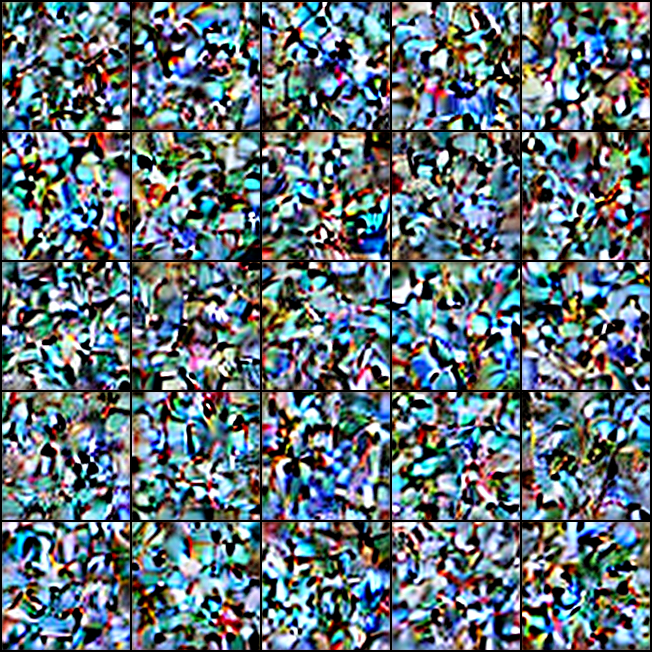

In [90]:
t_traj[0]
latent = latents_traj[0][4]
with torch.no_grad():
    image = pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0]
    image = pipeline.image_processor.postprocess(image, output_type="pil")

imgmtg = pil_images_to_grid(image)
imgmtg

In [55]:
pipeline.scheduler

DPMSolverMultistepScheduler {
  "_class_name": "DPMSolverMultistepScheduler",
  "_diffusers_version": "0.31.0",
  "algorithm_type": "dpmsolver++",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "dynamic_thresholding_ratio": 0.995,
  "euler_at_final": false,
  "final_sigmas_type": "zero",
  "lambda_min_clipped": -Infinity,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false,
  "use_lu_lambdas": false,
  "variance_type": null
}

In [24]:
validation_prompts

['triangle is to the upper left of square',
 'blue triangle is to the upper left of red square',
 'triangle is above and to the right of square',
 'blue circle is above and to the right of blue square',
 'triangle is to the left of square',
 'triangle is to the left of triangle',
 'circle is below red square',
 'red circle is to the left of blue square',
 'blue square is to the right of red circle',
 'red circle is above square',
 'triangle is above red circle',
 'red is above blue',
 'red is to the left of red',
 'blue triangle is above red triangle',
 'blue circle is above blue square']

In [23]:
image_logs

[{'validation_prompt': 'triangle is to the upper left of square',
  'images': [<PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image image mode=RGB size=128x128>,
   <PIL.Image.Image imag

### Hook the internal states 

In [26]:
pipeline.transformer

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x BasicTransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0):

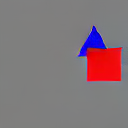

In [21]:
image_logs[0]['images'][0]

### Visualize attention masks

In [319]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple

class PixArtAttentionVisualizer:
    def __init__(self, pipe):
        self.pipe = pipe
        self.activation = defaultdict(list)
        self.hook_handles = []

    def clear_activation(self):
        self.activation = defaultdict(list)
    
    def hook_forger(self, key: str):
        """Create a hook to capture attention patterns"""
        def hook(module, input, output):
            self.activation[key].append(output.detach().cpu())
        return hook

    def hook_transformer_attention(self, module, module_id: str):
        """Hook both self-attention and cross-attention modules in PixArt"""
        hooks = []
        # For self-attention (attn1)
        if hasattr(module, 'attn1'):
            h1 = module.attn1.to_q.register_forward_hook(self.hook_forger(f"{module_id}_self_Q"))
            h2 = module.attn1.to_k.register_forward_hook(self.hook_forger(f"{module_id}_self_K"))
            hooks.extend([h1, h2])

        # For cross-attention (attn2)
        if hasattr(module, 'attn2'):
            h3 = module.attn2.to_q.register_forward_hook(self.hook_forger(f"{module_id}_cross_Q"))
            h4 = module.attn2.to_k.register_forward_hook(self.hook_forger(f"{module_id}_cross_K"))
            hooks.extend([h3, h4])

        return hooks

    def setup_hooks(self):
        """Set up hooks for all transformer blocks"""
        print("Setting up hooks for PixArt attention modules:")

        for block_idx, block in enumerate(self.pipe.transformer.transformer_blocks):
            print(f"- Block {block_idx}")
            hooks = self.hook_transformer_attention(block, f"block{block_idx:02d}")
            self.hook_handles.extend(hooks)

    def cleanup_hooks(self):
        """Remove all hooks"""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

    # def generate_with_attention(self, prompt: str, negative_prompt: str = "",
    #                           height: int = 1024, width: int = 1024,
    #                           num_inference_steps: int = 20,
    #                           guidance_scale: float = 4.5):
    #     """Generate image and collect attention patterns with CFG"""
    #     self.activation.clear()

    #     # Get both conditional and unconditional embeddings
    #     text_inputs = self.pipe.tokenizer(
    #         [negative_prompt, prompt],  # Process both prompts
    #         padding="max_length",
    #         max_length=120,
    #         truncation=True,
    #         return_tensors="pt"
    #     )

    #     # Get tokens for both negative and positive prompts
    #     neg_tokens_ids = text_inputs.input_ids[0][text_inputs.attention_mask[0].bool()]
    #     pos_tokens_ids = text_inputs.input_ids[1][text_inputs.attention_mask[1].bool()]

    #     neg_tokens = self.pipe.tokenizer.convert_ids_to_tokens(neg_tokens_ids)
    #     pos_tokens = self.pipe.tokenizer.convert_ids_to_tokens(pos_tokens_ids)

    #     # Set up hooks
    #     self.setup_hooks()

    #     try:
    #         # Generate image with CFG
    #         output = self.pipe(
    #             prompt,
    #             negative_prompt=negative_prompt,
    #             height=height,
    #             width=width,
    #             num_inference_steps=num_inference_steps,
    #             guidance_scale=guidance_scale,
    #         )

    #         # Stack collected activations
    #         for key in self.activation:
    #             if self.activation[key]:
    #                 self.activation[key] = torch.stack(self.activation[key], dim=0)

    #     finally:
    #         self.cleanup_hooks()

    #     return output, (neg_tokens, pos_tokens)

    def compute_attention(self, module_id: str, timestep: int, attn_type: str = 'self'):
        Q = self.activation[f"{module_id}_{attn_type}_Q"][timestep]
        K = self.activation[f"{module_id}_{attn_type}_K"][timestep]
        scale = K.shape[-1] ** -0.5
        attention = scale * torch.bmm(Q.float(), K.transpose(-1, -2).float())
        attention = torch.softmax(attention, dim=-1)
        # Split attention for unconditional and conditional paths
        uncond_attention = attention[:attention.shape[0]//2]
        cond_attention = attention[attention.shape[0]//2:]
        return uncond_attention, cond_attention
        
    
    def visualize_attention(self, module_id: str, timestep: int, tokens: Tuple[List[str], List[str]],
                          attn_type: str = 'self', figsize: Tuple[int, int] = (20, 15)):
        """Visualize attention patterns for both unconditional and conditional paths"""
        neg_tokens, pos_tokens = tokens
        Q = self.activation[f"{module_id}_{attn_type}_Q"][timestep]
        K = self.activation[f"{module_id}_{attn_type}_K"][timestep]

        if Q is None or K is None:
            print(f"No attention data found for {module_id} at timestep {timestep}")
            return

        # Compute attention scores for both paths
        scale = K.shape[-1] ** -0.5
        attention = scale * torch.bmm(Q.float(), K.transpose(-1, -2).float())
        attention = torch.softmax(attention, dim=-1)

        # Split attention for unconditional and conditional paths
        uncond_attention = attention[:attention.shape[0]//2]
        cond_attention = attention[attention.shape[0]//2:]

        # Create subplot for both paths
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot unconditional attention
        n_neg_tokens = min(16, len(neg_tokens))
        uncond_map = uncond_attention[0, :, :n_neg_tokens].reshape(-1, n_neg_tokens)
        sns.heatmap(uncond_map.cpu().numpy(), ax=ax1, cmap='viridis')
        ax1.set_title(f"Unconditional Attention\n(Negative Prompt)")
        ax1.set_xticks(np.arange(n_neg_tokens) + 0.5)
        ax1.set_xticklabels(neg_tokens[:n_neg_tokens], rotation=45)

        # Plot conditional attention
        n_pos_tokens = min(16, len(pos_tokens))
        cond_map = cond_attention[0, :, :n_pos_tokens].reshape(-1, n_pos_tokens)
        sns.heatmap(cond_map.cpu().numpy(), ax=ax2, cmap='viridis')
        ax2.set_title(f"Conditional Attention\n(Positive Prompt)")
        ax2.set_xticks(np.arange(n_pos_tokens) + 0.5)
        ax2.set_xticklabels(pos_tokens[:n_pos_tokens], rotation=45)

        plt.suptitle(f'{attn_type.capitalize()} Attention: {module_id}, Step {timestep}')
        plt.tight_layout()
        plt.show()

    def analyze_attention_patterns(self, prompt: str, negative_prompt: str = "",
                                 timesteps_to_show: List[int] = None,
                                 guidance_scale: float = 4.5):
        """Generate image and analyze attention patterns with CFG"""
        print(f"Analyzing attention patterns:")
        print(f"Positive prompt: {prompt}")
        print(f"Negative prompt: {negative_prompt}")

        # Generate image and collect attention
        output, tokens = self.generate_with_attention(
            prompt,
            negative_prompt=negative_prompt,
            guidance_scale=guidance_scale
        )

        # Show generated image
        plt.figure(figsize=(12, 12))
        plt.imshow(output.images[0])
        plt.title(f"Generated Image\nPrompt: {prompt}\nNegative Prompt: {negative_prompt}")
        plt.axis('off')
        plt.show()

        # If timesteps not specified, sample a few
        if timesteps_to_show is None:
            timesteps_to_show = list(range(0, 20, 5))

        # Visualize patterns for each transformer block
        for block_idx in range(len(self.pipe.transformer.transformer_blocks)):
            module_id = f"block{block_idx:02d}"
            print(f"\nAnalyzing Block {block_idx}")

            for timestep in timesteps_to_show:
                print(f"Timestep {timestep}")
                # Visualize self-attention
                self.visualize_attention(module_id, timestep, tokens, 'self')
                # Visualize cross-attention
                self.visualize_attention(module_id, timestep, tokens, 'cross')


In [320]:
attnvis.cleanup_hooks()

In [321]:
attnvis.cleanup_hooks()

attnvis = PixArtAttentionVisualizer(pipeline)
attnvis.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


In [242]:
validation_prompts

['triangle is to the upper left of square',
 'blue triangle is to the upper left of red square',
 'triangle is above and to the right of square',
 'blue circle is above and to the right of blue square',
 'triangle is to the left of square',
 'triangle is to the left of triangle',
 'circle is below red square',
 'red circle is to the left of blue square',
 'blue square is to the right of red circle',
 'red circle is above square',
 'triangle is above red circle',
 'red is above blue',
 'red is to the left of red',
 'blue triangle is above red triangle',
 'blue circle is above blue square']

In [243]:
image_logs_sel, latents_traj_sel, pred_traj_sel, t_traj_sel = visualize_prompts_with_traj(pipeline, validation_prompts[:1], prompt_cache_dir, config.model_max_length, weight_dtype)

torch.Size([50, 20, 4096])
torch.Size([50, 20])


In [244]:
attnvis.activation['block00_self_Q'][0].shape

torch.Size([50, 64, 768])

In [158]:
type(pipeline.transformer.transformer_blocks[0].attn1)

diffusers.models.attention_processor.Attention

In [166]:
pipeline.transformer.transformer_blocks[0].attn1.heads

12

In [245]:
from diffusers.models.attention_processor import Attention
attn_processor = Attention(query_dim=768, heads=8, )

<Axes: >

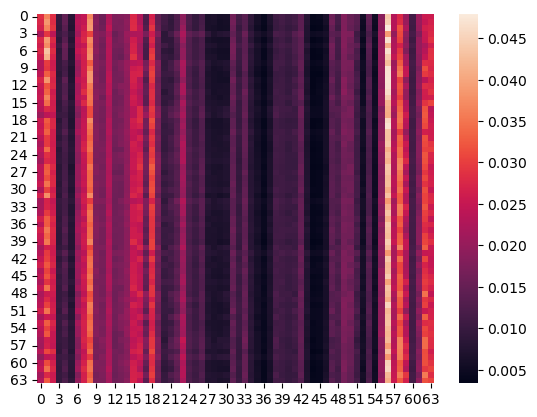

In [246]:
query = attn_processor.head_to_batch_dim(attnvis.activation['block00_self_Q'][0])
key = attn_processor.head_to_batch_dim(attnvis.activation['block00_self_K'][0])
attn_scores = attn_processor.get_attention_scores(query, key, attention_mask=None)
BH, Nimg, Nimg2 = attn_scores.shape
attn_scores_per_head = attn_scores.reshape(-1, attn_processor.heads, Nimg, Nimg2)
attn_scores_per_head.shape
sns.heatmap(attn_scores_per_head[0, 1].cpu().numpy())

In [208]:
validation_prompts

['triangle is to the upper left of square',
 'blue triangle is to the upper left of red square',
 'triangle is above and to the right of square',
 'blue circle is above and to the right of blue square',
 'triangle is to the left of square',
 'triangle is to the left of triangle',
 'circle is below red square',
 'red circle is to the left of blue square',
 'blue square is to the right of red circle',
 'red circle is above square',
 'triangle is above red circle',
 'red is above blue',
 'red is to the left of red',
 'blue triangle is above red triangle',
 'blue circle is above blue square']

In [292]:
from transformers import T5Tokenizer, T5EncoderModel

T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [334]:
image_logs_sel, latents_traj_sel, pred_traj_sel, t_traj_sel = visualize_prompts_with_traj(pipeline, validation_prompts[7:8], prompt_cache_dir, config.model_max_length, weight_dtype)

embed_infos = load_embed_and_mask(validation_prompts[7:8], prompt_cache_dir, config.model_max_length, device="cuda")
print(embed_infos[0]['prompt'])
prompt = embed_infos[0]['prompt']
attention_mask_raw = embed_infos[0]['emb_mask'].cpu()
word_tokens = tokenizer.tokenize(prompt)
word_tokens = [token.replace("▁", "") for token in word_tokens]
print(word_tokens)
print(embed_infos[-1]['prompt'])
attention_mask_uncond_raw = embed_infos[-1]['emb_mask'].cpu()

torch.Size([50, 20, 4096])
torch.Size([50, 20])
['caption_embeds', 'emb_mask', 'prompt']
red circle is to the left of blue square
['red', 'circle', 'is', 'to', 'the', 'left', 'of', 'blue', 'square']



In [335]:
img_per_prompt = 25 # number of images
sequence_length = config.model_max_length

attention_mask = attention_mask_raw.repeat(img_per_prompt, 1)
attention_mask_uncond = attention_mask_uncond_raw.repeat(img_per_prompt, 1)
attention_mask = torch.cat([attention_mask_uncond, attention_mask,], dim=0)

In [355]:
attn_scores_per_head[-1,0,:,:].sum(-1)


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [390]:
layer_i = 4 # note the 
timestep = -1
img_per_prompt = 25 # number of images
sequence_length = config.model_max_length

attention_mask = attention_mask_raw.repeat(img_per_prompt, 1)
attention_mask_uncond = attention_mask_uncond_raw.repeat(img_per_prompt, 1)
attention_mask = torch.cat([attention_mask_uncond, attention_mask,], dim=0)
attention_mask = (1 - attention_mask.to(torch.float32)) * -10000.0 # this is happening in the transformer 2d model  L399
attention_mask = attention_mask.unsqueeze(1)

attention_mask = attn_processor.prepare_attention_mask(attention_mask, sequence_length, img_per_prompt * 2) # this happens in the attention processor 
query = attn_processor.head_to_batch_dim(attnvis.activation[f'block{layer_i:02d}_cross_Q'][timestep])
key = attn_processor.head_to_batch_dim(attnvis.activation[f'block{layer_i:02d}_cross_K'][timestep])
# TODO: check if the attention mask is correct, currently it is not quite working 
attn_scores = attn_processor.get_attention_scores(query, key, attention_mask=attention_mask) 
BH, Nimg, Nlang = attn_scores.shape
attn_scores_per_head = attn_scores.reshape(img_per_prompt * 2, attn_processor.heads, Nimg, Nlang)
attn_scores_per_head.shape

torch.Size([50, 8, 64, 20])

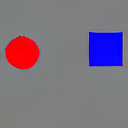

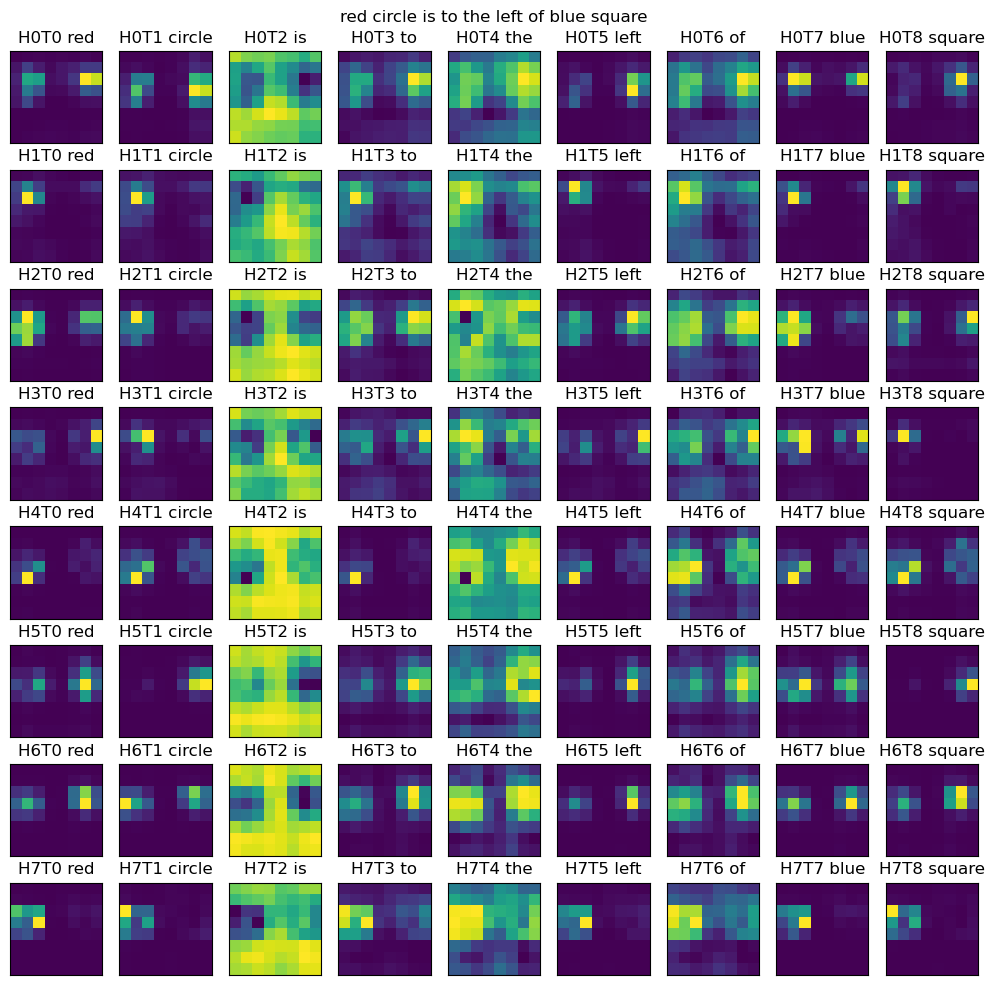

In [391]:
sample_id = 15
# head_id = 3
# token_id = 1
display(image_logs_sel[0]['images'][sample_id])
figh, axs = plt.subplots(8, len(word_tokens), figsize=(10, 10))
for head_id in range(8):
    for token_id in range(len(word_tokens)):
        ax = axs[head_id, token_id]
        ax.imshow(attn_scores_per_head[25 + sample_id, 
                                 head_id, :, 
                                 token_id].view(8, 8).cpu().numpy())
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f'H{head_id}T{token_id} {word_tokens[token_id]}')
        
plt.suptitle(f'{prompt}')
plt.tight_layout()


<Axes: >

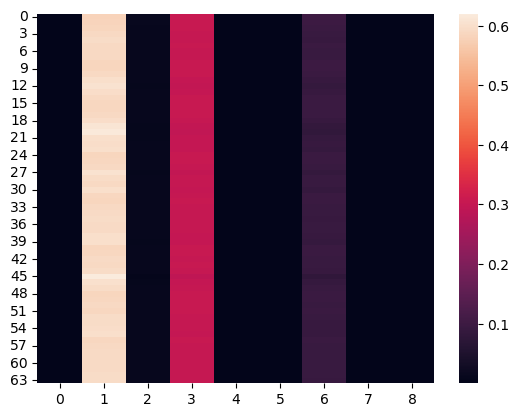

In [314]:
sns.heatmap(attn_scores_per_head[26, -2, :, :9].cpu().numpy())

In [157]:
attnvis.compute_attention("block00", 0, attn_type='self')

(tensor([[[0.0292, 0.0397, 0.0221,  ..., 0.0050, 0.0170, 0.0314],
          [0.0296, 0.0394, 0.0222,  ..., 0.0044, 0.0157, 0.0307],
          [0.0252, 0.0372, 0.0218,  ..., 0.0033, 0.0151, 0.0315],
          ...,
          [0.0190, 0.0321, 0.0197,  ..., 0.0034, 0.0149, 0.0292],
          [0.0200, 0.0324, 0.0197,  ..., 0.0032, 0.0180, 0.0312],
          [0.0200, 0.0318, 0.0211,  ..., 0.0037, 0.0158, 0.0332]],
 
         [[0.0284, 0.0495, 0.0136,  ..., 0.0033, 0.0087, 0.1630],
          [0.0265, 0.0490, 0.0142,  ..., 0.0037, 0.0090, 0.1584],
          [0.0259, 0.0469, 0.0139,  ..., 0.0032, 0.0080, 0.1750],
          ...,
          [0.0204, 0.0436, 0.0131,  ..., 0.0029, 0.0070, 0.1951],
          [0.0202, 0.0400, 0.0129,  ..., 0.0029, 0.0074, 0.2017],
          [0.0199, 0.0403, 0.0123,  ..., 0.0028, 0.0073, 0.1991]],
 
         [[0.0408, 0.0324, 0.0447,  ..., 0.0050, 0.0189, 0.0961],
          [0.0379, 0.0365, 0.0507,  ..., 0.0048, 0.0163, 0.0985],
          [0.0384, 0.0362, 0.0511,  ...,

In [142]:
attnvis.visualize_attention("block00", 0, [[0,0,0,0,0,0,0,0],[]])

AttributeError: 'list' object has no attribute 'shape'

In [140]:
list(attnvis.activation.keys())

['block00_self_Q',
 'block00_self_K',
 'block00_cross_Q',
 'block00_cross_K',
 'block01_self_Q',
 'block01_self_K',
 'block01_cross_Q',
 'block01_cross_K',
 'block02_self_Q',
 'block02_self_K',
 'block02_cross_Q',
 'block02_cross_K',
 'block03_self_Q',
 'block03_self_K',
 'block03_cross_Q',
 'block03_cross_K',
 'block04_self_Q',
 'block04_self_K',
 'block04_cross_Q',
 'block04_cross_K',
 'block05_self_Q',
 'block05_self_K',
 'block05_cross_Q',
 'block05_cross_K',
 'block06_self_Q',
 'block06_self_K',
 'block06_cross_Q',
 'block06_cross_K',
 'block07_self_Q',
 'block07_self_K',
 'block07_cross_Q',
 'block07_cross_K',
 'block08_self_Q',
 'block08_self_K',
 'block08_cross_Q',
 'block08_cross_K',
 'block09_self_Q',
 'block09_self_K',
 'block09_cross_Q',
 'block09_cross_K',
 'block10_self_Q',
 'block10_self_K',
 'block10_cross_Q',
 'block10_cross_K',
 'block11_self_Q',
 'block11_self_K',
 'block11_cross_Q',
 'block11_cross_K']